In [1]:
# from deeppavlov.models.spelling_correction.levenshtein.searcher_component import LevenshteinSearcherComponent
import numpy as np
DATA_PATH = "/home/alx/Cloud/spell_corr/py_spelling_corrector/data/"


In [2]:
from dp_components.kenlm_elector import KenlmElector
from dp_components.levenshtein_searcher import LevenshteinSearcherComponent
from dp_components.sc_candidates_generator import SpellingCorrectionCandidatesGenerator

In [4]:
from copy import copy, deepcopy

class LanguageModel():
    def tokenize(self, sent_str):
        pass

    def estimate_likelihood(self, sent_str):
        pass

    def score_sentences(self, sentences):
        return np.random.rand(len(sentences))

class TokenHypothesis():
    def __init__(self, text, err_score=0.0):
        self.text = text
#         self.lm_score = 0
        # score for error:
        self.err_score = err_score
        # counter which helps to estimate how many words was merged
        # this is used to multiply likelihood of unknown word
        self.merges_count = 0
        
    def merge_with_suffix(self, suffix_str, err_score):
        self.text += suffix_str
        self.err_score += err_score
        self.merges_count+=1
        return self
    
    def __repr__(self):
        return "[HypoTok: %s]" % self.text
    
class SentenceHypothesis():
    def __init__(self, text):
        self.text = text
#         self.score = np.nan
        self.lm_score = 0
        # score for error:
#         self.err_score = err_score
        self.final_score = 0.0
        # token hypotheses of the sentence
        self.token_hypotheses = []
        
    def total_score(self):
        return self.lm_score+self.err_score()
    
    def err_score(self):
        # calculates error score from token errors
        total_error = 0
        for each_tok_hyp in self.token_hypotheses:
            total_error+=each_tok_hyp.err_score
        return total_error
    
    def fork_for_each_suffix(self, suffixes, error_scores=None):
        """Given a list of suffixes strings it forks the current hypotheses into several
        hypotheses for each suffix.

        : param error_scores: score for suffix, usually negative value (logit score), suffix error score is incremented to
        baseline hypothesis score
        """
        hypotheses_list = []
        #         import ipdb; ipdb.set_trace()
        for idx, each_suffix in enumerate(suffixes):
            new_sentence_hypothesis = deepcopy(self)
            new_sentence_hypothesis.text += each_suffix

            if each_suffix[0] == " ":
                # new token case
                # if suffix starts with space character, then we have a token split
                tok_hypothesis = TokenHypothesis(each_suffix[1:], error_scores[idx])
                new_sentence_hypothesis.token_hypotheses.append(tok_hypothesis)

            else:
                # hypotheses of continuation of token
                tokens_count = len(new_sentence_hypothesis.token_hypotheses)
                if tokens_count == 0:
                    # the first token in the sentence
                    tok_hypothesis = TokenHypothesis(each_suffix, error_scores[idx])
                    new_sentence_hypothesis.token_hypotheses.append(tok_hypothesis)

                else:
                    # get last token and merge it with suffix:
                    last_token_hypothesis = new_sentence_hypothesis.token_hypotheses[
                        tokens_count - 1]
                    # TODO do we really need a deepcopy here? (I suppose token hypothesis is already deepcopied in sentencece hypothesis deepcopy?)
                    last_token_hypothesis = deepcopy(last_token_hypothesis)
#                     last_token_hypothesis.merge_with_suffix(each_suffix[1:], error_scores[idx])
                    last_token_hypothesis.merge_with_suffix(each_suffix, error_scores[idx])
                    # substitute the last token hypothesis with enlarged one
                    new_sentence_hypothesis.token_hypotheses[
                        tokens_count - 1] = last_token_hypothesis

            hypotheses_list.append(new_sentence_hypothesis)

        return hypotheses_list

    def __repr__(self):        
        if self.final_score!=0:
            out_text = " score: %f" % self.final_score        
        else:
            out_text = " score: %f" % self.total_score()        
        text = "hypothesis: %s" % self.text
        return text + out_text
    
class HypothesesHub():
    def __init__(self):
        # init with null hypothesis:
        self.hypotheses = [SentenceHypothesis("")]

    def get_scores(self):
        """Returns summarized scores Error + LM score"""
        scores = [each_hypo.total_score() for each_hypo in self.hypotheses]
        return scores

    def append_partial_hypotheses(self, partial_candidates, error_scores=None):
        """
        For each hypothesis in the hub it appends all candidates
        :param partial_candidates:
        :return: updated self
        """
        new_hypotheses = []
        if self.hypotheses:
            for each_hypothesis in self.hypotheses:
                hypos = each_hypothesis.fork_for_each_suffix(partial_candidates, error_scores=error_scores)
                new_hypotheses += hypos
        else:
            print("No hypotheses!!!!")
        self.hypotheses = new_hypotheses
        return self

    
class SpellingCorrector():
    # language_model;
    # error model;
    def __init__(self, sccg=None, language_model=None):
        """
        sccg - spelling corrector hypotheses generator instance
        lang_model - language model instance, by default KenLM
        """
        
        # setup hypotheses generator:
        if not sccg:
            self.sccg = SpellingCorrectionCandidatesGenerator()
        else:
            self.sccg = sccg
        
        # setup language model:
        if not language_model:
            # KenLM Elector as LM:
            ROOT_PATH = "~/.deeppavlov"
            DOWNLOADS_PATH = ROOT_PATH + "/downloads"        
            self.lm = KenlmElector(load_path=DOWNLOADS_PATH+"/language_models/ru_wiyalen_no_punkt.arpa.binary")

        else:
            self.lm = language_model
    
    def score_hypothesis(self, sentence_hypothesis):
        """Scores hypothesis by KenLM with accounting """
        state = kenlm.State()
        prev_state = state
        self.lm.lm.NullContextWrite(state)
        accum = 0.0
        for each_tok_hyp in sentence_hypothesis.token_hypotheses:
            next_state = kenlm.State()
            uniscore= self.lm.lm.BaseScore(prev_state, each_tok_hyp.text, next_state)
            if each_tok_hyp.merges_count>0:
                # check each_tok_hyp is OOV! otherwise heuristics is incorrect
                uniscore *= each_tok_hyp.merges_count+1
            if each_tok_hyp.err_score:
                assert each_tok_hyp.err_score<=0
                uniscore += each_tok_hyp.err_score
#             print(each_tok_hyp, uniscore)
            accum += uniscore
            prev_state = next_state
        return accum
            
            
    def score_hypotheses_hub(self, hypotheses_hub):
        """Score hypotheses by LM
        Command to run scoring of all hypotheses by language model scoring function
        :return: list of scored hypotheses
        
        """
        scores = []
        for each_sentence_hypothesis in hypotheses_hub.hypotheses:
            each_sentence_hypothesis.final_score = self.score_hypothesis(each_sentence_hypothesis)
            scores.append(each_sentence_hypothesis.final_score)
            
        return scores

    def score_hypotheses_hub_optimized(self, hypotheses_hub):
        """Score hypotheses by LM
        
        Command to run scoring of all hypotheses by language model scoring function
        
        Optimized version.
        
        We need to preprocess all hypotheses by creating prefix tree and using beam search to avoid 
        combinatorial blast
        
        
        :return: list of scored hypotheses
        
        """
        scores = []
        for each_sentence_hypothesis in hypotheses_hub.hypotheses:
            each_sentence_hypothesis.final_score = self.score_hypothesis(each_sentence_hypothesis)
            scores.append(each_sentence_hypothesis.final_score)
            
        return scores
    
    def prune_low_prob_hypotheses(self, hypo_hub, max_number_of_hypotheses=200):
        """
        Prunes hypotheses that has low probability.
                
        :return:
        """
        
        # number check
        hypo_hub.hypotheses = sorted(hypo_hub.hypotheses, key=lambda x: x.final_score, reverse=True)        
        if len(hypo_hub.hypotheses)>max_number_of_hypotheses:
            # prune those which are the worst
            hypo_hub.hypotheses = hypo_hub.hypotheses[:max_number_of_hypotheses]     
        
        return hypo_hub.hypotheses
    
    def analyze_sentence(self, sentence):
        """
        Method for analyzing sentence: generating hypotheses and scoring them
        
        :param sentence: str, sentence with errors
        :return: correction hypotheses of the sentence
        """
        self.hypo_hub = HypothesesHub()
        # preprocessing:
        # TODO make lowercasing revertible:
        sentence = self.lowercase(sentence)        
        tokenized_input = self._tokenize(sentence)
        for idx, each_tok in enumerate(tokenized_input):
            # TODO optionally you could pass left and right context
            err_scores, tok_candidates = self.sccg.gen_candidates(each_tok)
            if idx>0:
                # TODO optionally you could pass left and right context
                err_scores, tok_candidates = self.sccg.variate_with_prefixes(tok_candidates, err_scores)
            
            self.hypo_hub = self.hypo_hub.append_partial_hypotheses(tok_candidates, err_scores)
            
            # group hypotheses by tokenized lengths and then use standrd KenLM scoring function?
            l_scores = self.score_hypotheses_hub(self.hypo_hub)
            self.prune_low_prob_hypotheses(self.hypo_hub)
            
        return self.hypo_hub.hypotheses
    
    def __call__(self, input_sentences_batch):
        """
        Given a batch of sentences it returns a batch of corrected sentences
        
        """
        outputs = []
        for each_sent in input_sentences_batch:
            hypotheses = self.analyze_sentence(each_sent)
            the_best_hypothesis = hypotheses[0]
            outputs.append(the_best_hypothesis.text)
        return outputs
    
    def lowercase(self, sent_str):
        return sent_str.lower()
    
    def _tokenize(self, sent_str):
        return sent_str.split()

    def predict_correct(self, sentence_str):
        """
        predicts correction of the sentence
        :param sentence_str:
        :return:
        """

        pass
    
# UNFINISHED
# class SpellingCorrectorGraphy(SpellingCorrector):
#     """
#     The spelling corrector which uses graph representation of hypothesis space
#     """
#     def analyze_sentence(self, sentence):
#         """
#         Method for analyzing sentence: generating hypotheses and scoring them
        
#         :param sentence: str, sentence with errors
#         :return: correction hypotheses of the sentence
#         """
#         self.hypo_hub = HypothesesHub()
#         # preprocessing:
#         # TODO make lowercasing revertible:
#         sentence = self.lowercase(sentence)        
#         tokenized_input = self._tokenize(sentence)
#         for idx, each_tok in enumerate(tokenized_input):
#             # TODO optionally you could pass left and right context
#             err_scores, tok_candidates = self.sccg.gen_candidates(each_tok)
#             if idx>0:
#                 # TODO optionally you could pass left and right context
#                 err_scores, tok_candidates = self.sccg.variate_with_prefixes(tok_candidates, err_scores)
            
#             self.hypo_hub = self.hypo_hub.append_partial_hypotheses(tok_candidates, err_scores)
            
#             # group hypotheses by tokenized lengths and then use standrd KenLM scoring function?
#             l_scores = self.score_hypotheses_hub(self.hypo_hub)
#             self.prune_low_prob_hypotheses(self.hypo_hub)
            
#         return self.hypo_hub.hypotheses
    

In [11]:
sccg.variate_with_prefixes(["то"], [0.0])

([-6.0, 0.0, -4.0], ['то', ' то', '-то'])

In [5]:
# init it once because it loads for 2.5 minutes:
sccg = SpellingCorrectionCandidatesGenerator()

In [6]:
sc = SpellingCorrector(sccg=sccg)

In [7]:
hypotheses = sc.analyze_sentence("когда нибудь")
hypotheses

[hypothesis: когда нибудь score: -7.640179,
 hypothesis: когда-нибудь score: -12.643865,
 hypothesis: тогда нибудь score: -14.637478,
 hypothesis: кода нибудь score: -15.689139,
 hypothesis: когда ни будь score: -16.147324,
 hypothesis: корда нибудь score: -17.100760,
 hypothesis: когданибудь score: -18.130759,
 hypothesis: ко да нибудь score: -18.561239,
 hypothesis: тогда ни будь score: -20.326597,
 hypothesis: кода ни будь score: -21.378259,
 hypothesis: кода-нибудь score: -22.004326,
 hypothesis: тогда-нибудь score: -22.250359,
 hypothesis: корда-нибудь score: -22.250359,
 hypothesis: ко да-нибудь score: -22.250359,
 hypothesis: когдани будь score: -22.750359,
 hypothesis: тогданибудь score: -22.750359,
 hypothesis: коданибудь score: -22.750359,
 hypothesis: корданибудь score: -22.750359,
 hypothesis: ко данибудь score: -22.750359,
 hypothesis: корда ни будь score: -22.789880,
 hypothesis: ко да ни будь score: -24.250359,
 hypothesis: тогдани будь score: -26.750359,
 hypothesis: ко

In [8]:
sccg.gen_candidates("нибудь")

([-4.0, 0], ['ни будь', 'нибудь'])

In [9]:
sccg.lsc([["нибудь"]])

[[[(-4.0, 'ни будь'), (0, 'нибудь')]]]

In [38]:
scored_candidates=sccg.lsc([["нибудь"]])[0][0]
scores, w_forms = zip(*scored_candidates)
w_forms = list(w_forms)
scores = list(scores)
print(w_forms, scores)

['ни будь', 'нибудь'] [-4.0, -8.0]


In [11]:
sentence = "когда нибудь"
hypo_hub = HypothesesHub()

tokenized_input = sc._tokenize(sentence)
for idx, each_tok in enumerate(tokenized_input):
    # TODO optionally you could pass left and right context
    err_scores, tok_candidates = sccg.gen_candidates(each_tok)
    print(err_scores, tok_candidates)
    if idx>0:
        # TODO optionally you could pass left and right context
        err_scores, tok_candidates = sccg.variate_with_prefixes(tok_candidates, err_scores)

    hypo_hub = hypo_hub.append_partial_hypotheses(tok_candidates, err_scores)

    # group hypotheses by tokenized lengths and then use standrd KenLM scoring function?
    l_scores = sc.score_hypotheses_hub(hypo_hub)
    sc.prune_low_prob_hypotheses(hypo_hub)

print(hypo_hub.hypotheses)

[-0.0, -4.0, -4.0, -4.0, -4.0] ['когда', 'кода', 'корда', 'ко да', 'тогда']
[-4.0, 0] ['ни будь', 'нибудь']
[hypothesis: когда нибудь score: -7.640179, hypothesis: когда-нибудь score: -12.643865, hypothesis: тогда нибудь score: -14.637478, hypothesis: кода нибудь score: -15.689139, hypothesis: когда ни будь score: -16.147324, hypothesis: корда нибудь score: -17.100760, hypothesis: когданибудь score: -18.130759, hypothesis: ко да нибудь score: -18.561239, hypothesis: тогда ни будь score: -20.326597, hypothesis: кода ни будь score: -21.378259, hypothesis: кода-нибудь score: -22.004326, hypothesis: тогда-нибудь score: -22.250359, hypothesis: корда-нибудь score: -22.250359, hypothesis: ко да-нибудь score: -22.250359, hypothesis: когдани будь score: -22.750359, hypothesis: тогданибудь score: -22.750359, hypothesis: коданибудь score: -22.750359, hypothesis: корданибудь score: -22.750359, hypothesis: ко данибудь score: -22.750359, hypothesis: корда ни будь score: -22.789880, hypothesis: ко да

In [10]:
hypotheses[2].err_score()

-4.0

In [25]:
hypotheses[3].token_hypotheses[0].err_score

-10.0

In [27]:
hypotheses[3].token_hypotheses[0].text

'когда-нибудь'

In [6]:
hypotheses = sc.analyze_sentence("привет помпушка")
hypotheses

[hypothesis: привет пампушка score: -17.856689,
 hypothesis: привет подпушка score: -18.043473,
 hypothesis: привет помпу ка score: -18.166489,
 hypothesis: привет пом ушка score: -18.166489,
 hypothesis: привет помп ушка score: -18.166489,
 hypothesis: привет попушка score: -18.166489,
 hypothesis: привет по пушка score: -18.166489,
 hypothesis: привет пом пушка score: -18.166489,
 hypothesis: привел пампушка score: -20.849180,
 hypothesis: примет пампушка score: -20.957743,
 hypothesis: привел подпушка score: -21.035964,
 hypothesis: примет подпушка score: -21.144526,
 hypothesis: привел помпу ка score: -21.158980,
 hypothesis: привел пом ушка score: -21.158980,
 hypothesis: привел помп ушка score: -21.158980,
 hypothesis: привел попушка score: -21.158980,
 hypothesis: привел по пушка score: -21.158980,
 hypothesis: привел пом пушка score: -21.158980,
 hypothesis: примет помпу ка score: -21.267542,
 hypothesis: примет пом ушка score: -21.267542,
 hypothesis: примет помп ушка score: -

In [19]:
hypotheses = sc.analyze_sentence("мыприехали вдеревню")
hypotheses

[hypothesis: мыприехали вдеревню score: -16.250359,
 hypothesis: мыприехали деревню score: -16.987349,
 hypothesis: мыприехаливдеревню score: -18.750359,
 hypothesis: мыприехали в деревню score: -20.250359,
 hypothesis: м приехали вдеревню score: -20.250359,
 hypothesis: мы приехали вдеревню score: -20.250359,
 hypothesis: м приехали деревню score: -20.987349,
 hypothesis: мы приехали деревню score: -20.987349,
 hypothesis: мыприехалидеревню score: -22.750359,
 hypothesis: мыприехалив деревню score: -22.750359,
 hypothesis: м приехаливдеревню score: -22.750359,
 hypothesis: мы приехаливдеревню score: -22.750359,
 hypothesis: м приехали в деревню score: -24.250359,
 hypothesis: мы приехали в деревню score: -24.250359,
 hypothesis: м приехалидеревню score: -26.750359,
 hypothesis: м приехалив деревню score: -26.750359,
 hypothesis: мы приехалидеревню score: -26.750359,
 hypothesis: мы приехалив деревню score: -26.750359]

In [22]:
hypotheses[13].err_score()

-8.0

# Evaluate model

In [12]:
DIALOG_DATA_PATH = 'data/dialog/'
# Train data
TRAIN_ERRONEOUS_DATA = DIALOG_DATA_PATH + "source_sents.txt"
TRAIN_GOLDEN_DATA = DIALOG_DATA_PATH + "corrected_sents.txt"

# Test data
TEST_ERRONEOUS_DATA = DIALOG_DATA_PATH + "test_sample_testset.txt"
TEST_GOLDEN_DATA = DIALOG_DATA_PATH + "corr_sample_testset.txt"

In [13]:
with open(TEST_ERRONEOUS_DATA, 'r') as sents_file:
    erroneous_lines = sents_file.readlines()
    erroneous_lines = [line.strip() for line in erroneous_lines]
    
with open(TEST_GOLDEN_DATA, 'r') as sents_file:
    golden_lines = sents_file.readlines()
    golden_lines = [line.strip() for line in golden_lines]

In [14]:
from evaluate import evaluate_spelling_corrector
import datetime as dt

In [15]:
start_index=4
fin_index = 13
start_dt = dt.datetime.now()
hypotheses = sc(erroneous_lines[start_index:fin_index])
fin_dt = dt.datetime.now()
print(fin_dt-start_dt)

0:02:34.719621


In [16]:
hypotheses

['судьба человека может складываться очень разнообразно в жизни много прекрасных светлых радостных моментов',
 'а я думаю вот если бы хозяин этой лодки тебе ее подарил и ты бы собрал знакомых и устроил на этой лодке большие катание с размахом',
 'например парадный портрет николая ii при орденах и регалиях освященный как икона и снабженный 5-рублевой монетой и роскошным текстом снизу',
 'двубортное кашемировое пальто песочного цвета классическог фасона',
 'поговорила с директором и он мне обещал позвонить вечером и сказать берет он меня на работу',
 'схездил потом в ркб оказалось что на нем 3 царапины купил мази и капли',
 'но даже когда мы приблизились к нижнему уровню замка я поверить не могла что он такой огромный как показывалось на карте',
 'давно стоит понять что в этой жизни никто не делает так как лутче тебе',
 'а вообще конечно не представляю как все пятьдесят лет все забавляются над дядькой']

In [17]:
results = evaluate_spelling_corrector(erroneous_lines[start_index:fin_index], 
                                      golden_lines[start_index:fin_index], 
                                      hypotheses)
print(results['precision'])
print(results['recall'])
print(results['f_measure'])

Precision=75.00 Recall=42.86 FMeasure=54.55
3 4 7
0.75
0.42857142857142855
0.5454545454545454


In [ ]:
# full test evaluation

In [ ]:
start_dt = dt.datetime.now()
hypotheses = sc(erroneous_lines)
fin_dt = dt.datetime.now()
print(fin_dt-start_dt)

In [12]:
results = evaluate_spelling_corrector(erroneous_lines, golden_lines, hypotheses)
print(results['precision'])
print(results['recall'])
print(results['f_measure'])

Precision=54.67 Recall=57.13 FMeasure=55.87
1130 2067 1978
0.5466860183841316
0.5712841253791708
0.5587144622991348


In [ ]:
erroneous_lines

# Graph Based Hypotheses Trimmer

Assumptions:
1. We have a graph of token hypotheses 
2. we have a autoregressive language model LM
3. Graph has a root node (the place where all sentence hypotheses starts)
4. Algorithm goes through a graph with breadth search
5. and iteratively trims bad hypotheses from analysis

In [ ]:

class HypothesesGraph():
    """
    sentence hypotheses
    tokens hypotheses
    """
    def __init__(self):
        self.root_node = None
        self.fin_node = None

    def calculate_lm_scores(self, lm_obj):
        """
        Runs the process of calculation of hypotheses scores
        
        1. Starts from fin_node and requests prefix_hypotheses.
        2. 
        """
        pass
        
        
class GraphNode():
    """ 
    A token hypothesis of segment of Input Sentence
    
    
    """
    def __init__(self, token_hypothesis):
        # partial hypotheses that are produced after attaching this node to all prefixes hypotheses
        self.output_hypotheses = []
        
        # boolean flag that marks that all prefix hypotheses are calculated
        self.calculated_outputs = False
        
        self.token_hypothesis = token_hypothesis
    
    def get_prefix_hypotheses(self, top_k=-1):
        """
        For a node collects hypotheses from previous stage (all parent nodes) 
        and filters out the ones with low likelihood
        """
        prefix_hypotheses = []
        for each_prefix_node in self.from:        
            if len(each_prefix_node.output_hypotheses)>0:
                prefix_hypotheses += each_prefix_node.output_hypotheses
            else:
                raise Exception("prefix Node %s is unfilled!" % each_prefix_node)
        
        hypos = sorted(prefix_hypotheses, key=lambda x: x.lm_score(), reverse=True)
        
        if top_k>0:
            # make pruning:
            hypos = hypos[:top_k]
            
        return hypos
    
    def push_to_output_hypotheses(self, hypothesis):
        """
        adds a hypothesis into list of output hypotheses
        """
        self.output_hypotheses.append(hypothesis)


def calculate_output_hypotheses_for_node(node, lm):
    """
    Calculates output_hypotheses for a node using prefix_hypotheses and information about node's TokenHypothesis
    """
    partial_sentence_hypotheses = node.get_prefix_hypotheses(top_k=-1)
    
    # to assure that we dont append twice
    assert len(node.output_hypotheses)==0
    
    for each_input_hypothesis in partial_sentence_hypotheses:

        output_hypothesis, score = lm.score(each_input_hypothesis, each_child.token_hypothesis)

        node.push_to_output_hypotheses(output_hypothesis)
    return node


def analyze_with_lm(graph, lm, start_node=None):
    """
    Method to calculate likelihoods one stage deeper
    """
    if not start_node:
        current_node = graph.root_node        
    else: 
        current_node = start_node
        
    for each_child in current_node.to:
        # each_child has a set of prefix hypotheses
        # we need to calc them all
        
        each_child = calculate_output_hypotheses_for_node(each_child, lm)
        # add chld to agenda?
        # how to avoid adding twice?
        
        # node is finished. we can go deeper
    
    # here all children are processed and we can go deeper    
    return current_node.to 
        

def analyze_graph_with_lm(graph, lm):
    agenda = [graph.root_node]
    
    while len(agenda)>0:
        
    processed_nodes = analyze_with_lm(graph, lm)
    
    for each_processed_node in processed_nodes:
        nodes_for_next_step = analyze_with_lm(graph, lm, start_node=each_processed_node)
    


In [ ]:
root_node = GraphNode()

мамамыла
мама
мыла 
рыла
раму
ламу
маму
мамамылараму
мылом
мы
лом

In [ ]:
# NetworkX

In [39]:
import networkx as nx
G = nx.DiGraph()

root_node = "<S" 

mamamila_12 = "мамамыла" 
mama_1 = "мама" 
dama_1 = "дама" 

mila_2 = "мыла" 
rila_2 = "рыла" 

ramu_3 = "раму"
lamu_3 = "ламу" 

mi_4 = "мы"
lom_5 = "лом"
milom_45 = "мылом"

fin_node = "S>" 

# G.add_node(root_node)

# G.add_node(mamamila_12)
# G.add_node(mama_1)
# G.add_node(dama_1)

# G.add_node(fin_node)

G.add_edge(root_node, mamamila_12)
G.add_edge(root_node, mama_1)
G.add_edge(root_node, dama_1)

G.add_edge(mama_1, mila_2)
G.add_edge(dama_1, mila_2)
G.add_edge(mama_1, rila_2)
G.add_edge(dama_1, rila_2)

G.add_edge(mamamila_12, ramu_3)
G.add_edge(mamamila_12, lamu_3)
G.add_edge(mila_2, ramu_3)
G.add_edge(mila_2, lamu_3)
G.add_edge(rila_2, ramu_3)
G.add_edge(rila_2, lamu_3)

G.add_edge(ramu_3, mi_4)
G.add_edge(ramu_3, milom_45)

G.add_edge(lamu_3, mi_4)
G.add_edge(lamu_3, milom_45)


G.add_edge(mi_4, lom_5)

G.add_edge(milom_45, fin_node)
G.add_edge(lom_5, fin_node)

In [3]:
G

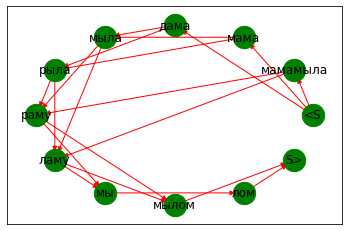

In [71]:
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt

# g1 = nx.petersen_graph()
# pos = nx.spring_layout(G)
pos = nx.shell_layout(G)
nx.draw_networkx_nodes(G, pos, node_color='g',
                       node_size = 500)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, edge_color='r', arrows=True)
# nx.draw_networkx_edges(G, pos, edgelist=black_edges, arrows=False)
plt.show()


# nx.draw(G)
# nx.draw_networkx_labels(G, pos=nx.spring_layout(G))
# # nx.draw_networkx_labels(G, pos=nx.random_layout(G))
# plt.show()

In [ ]:
#####

In [ ]:
ROOT_PATH = "~/.deeppavlov"
DOWNLOADS_PATH = ROOT_PATH + "/downloads"        
kenlm_model = KenlmElector(load_path=DOWNLOADS_PATH+"/language_models/ru_wiyalen_no_punkt.arpa.binary")
# state = kenlm.State()

def score_hypothesis_by_tokens(kenlm_model, sentence_hypothesis):
    state = kenlm.State()
    prev_state = state
    kenlm_model.lm.BeginSentenceWrite(state)
    
    accum = 0.0
    for each_tok_hyp in sentence_hypothesis.token_hypotheses:
        next_state = kenlm.State()
        uniscore=kenlm_model.lm.BaseScore(prev_state, each_tok_hyp.text, next_state)
        if each_tok_hyp.merges_count>0:
            # check each_tok_hyp is OOV! otherwise heuristics is incorrect
            uniscore *= each_tok_hyp.merges_count+1
        print(each_tok_hyp, uniscore)
        accum += uniscore
        prev_state = next_state
        
def score_hypothesis_by_tokens_nos(kenlm_model, sentence_hypothesis):
    state = kenlm.State()
    prev_state = state
    kenlm_model.lm.NullContextWrite(state)
    accum = 0.0
    for each_tok_hyp in sentence_hypothesis.token_hypotheses:
        next_state = kenlm.State()
        uniscore=kenlm_model.lm.BaseScore(prev_state, each_tok_hyp.text, next_state)
        if each_tok_hyp.merges_count>0:
            # check each_tok_hyp is OOV! otherwise heuristics is incorrect
            uniscore *= each_tok_hyp.merges_count+1
#         print(each_tok_hyp, uniscore)
        accum += uniscore
        prev_state = next_state

# Trie Optimization Experiment

In [ ]:

import datrie

# alphabet of the language:
alphabet = 'abcdefghijklmnopqrstuvwxyz 1234567890абвгдеёжзиёклмнопрстуфхцчшщъыьэюя-'

class TrieHypothesesManager():
    def __init__(alphabet):
        self.trie = datrie.Trie(alphabet)
        
    def push_hypotheses_hub(self, hypotheses):
        pass
    
    def analyze_hypotheses_with_lm(self, lm):
        pass
    
    
    def prune_hypotheses(self):
        pass